<!-- DATA PROVIDER INSTRUCTIONS

1. Provide the name of your dataset, replacing the bracketed placeholder text.
2. Update the Registry of Open Data landing page URL, by replacing the bracketed placeholder text. The [REGISTRY_YAML_NAME] will correspond to the name of the YAML document in your pull request to the Registry of Open Data on Github, minus the .yaml file extension.
3. Remove these comment blocks when you have completed each section.

DATA PROVIDER INSTRUCTIONS -->

# Get to Know a Dataset: DANDI Archive

> **Def:** A _Dandiset_ is a collection of neurophysiology data and metadata hosted on the [DANDI Archive](https://dandiarchive.org/).

This notebook serves as a guided tour of the [Distributed Archive for Neurophysiology Data Integration (DANDI)](https://registry.opendata.aws/dandiarchive/), which holds hundreds of Dandisets with neurodata modalities spanning the
diverse fields of microscopy, optogenetics, intracellular and extracellular electrophysiology, and optophysiology. To
 showcase this diversity, we will demonstrate examples taken from several key Dandisets. For even more [usage guides](https://docs.dandiarchive.org/user-guide-using/exploring-dandisets/),
[dataset-specific tutorials](https://dandi.github.io/example-notebooks/), and general documentation, check out the main
[DANDI Docs](https://docs.dandiarchive.org/).

<!-- DATA PROVIDER INSTRUCTIONS

The goal of this section is to orient users to the structure of your dataset. 

1. How are key prefixes and objects organized in your S3 bucket?
2. What kinds of filetypes are represented in your dataset?
3. Explain with text what users are expected to encounter, and then demonstrate with code the organizational framework you applied when creating your dataset.
4. The responses to each question section are meant to be expanded or replaced as dictated by your dataset

DATA PROVIDER INSTRUCTIONS -->

### Q: How have you organized your S3 bucket? Help us understand the key prefix structure.

DANDI provides a [web interface](https://dandiarchive.org/dandiset), [REST API](https://api.dandiarchive.org/api/docs/swagger/),
and [command-line tool](https://pypi.org/project/dandi/) to help users intuitively navigate the contents.

Let's start by choosing a random Dandiset from the web interface (for example, [000003](https://dandiarchive.org/dandiset/000003/0.250624.0409))
and navigating to its ["Files" tab](https://dandiarchive.org/dandiset/000003/0.250624.0409/files).

We can see that a Dandiset is organized as a collection of folders organized by subject ID.

Each folder contains files named according to session ID or other unique discriminators.

```text
000003/
├── sub-YutaMouse20/
│   ├── sub-YutaMouse20_ses-YutaMouse20-140321_behavior+ecephys.nwb
│   ├── sub-YutaMouse20_ses-YutaMouse20-140324_behavior+ecephys.nwb
│   └── ...
├── sub-YutaMouse23/
│   └── ...
└──...
```


At the lowest level of the S3 bucket, DANDI uses a sophisticated checksum-based object store to deduplicate assets.

Every file uploaded to the archive is given a prefix structure in the S3 bucket similar to:

```
s3://dandiarchive/blobs/fa3/c57/fa3c5758-1e3e-4aeb-8d97-ad2e6032d8c8
...
s3://dandiarchive/blobs/<first three characters of ID>/<next three characters of ID>/<full ID>
```

which is not very human-readable. As such, we do not recommend navigating the S3 bucket directly.

Instead, we recommend using the other methods to explore the archive, which maps the file contents to their
underlying storage pattern.

### Setup

First we will install and import the Python libraries required throughout this notebook.

In [75]:
# This notebook requires the following additional libraries
!pip install -q dandi matplotlib remfile

# Import the libraries required for this notebook
from pathlib import Path

import h5py
import remfile
import matplotlib.pyplot as plt
from dandi.dandiapi import DandiAPIClient
from pynwb import read_nwb, NWBHDF5IO

Next, we will initialize our DANDI API client to interact with the archive database and list out a few of the
available Dandisets.

In [11]:
client = DandiAPIClient()
dandisets = list(client.get_dandisets())

# Print the dandiset IDs and titles of the first 3 dandisets
for dandiset in dandisets[:3]:
    print(f"{dandiset.identifier}: {dandiset.get_raw_metadata()["name"]}")

000003: Physiological Properties and Behavioral Correlates of Hippocampal Granule Cells and Mossy Cells
000004: A NWB-based dataset and processing pipeline of human single-neuron activity during a declarative memory task
000005: Electrophysiology data from thalamic and cortical neurons during somatosensation


Now let's return to our first example Dandiset and list out a few of its contents.

In [14]:
dandiset = client.get_dandiset(dandiset_id="000003", version_id="0.250624.0409")
assets = list(dandiset.get_assets())

# Print the file paths as seen on the DANDI web interface
for asset in assets[:3]:
    print(asset.get_raw_metadata()["path"])

sub-YutaMouse20/sub-YutaMouse20_ses-YutaMouse20-140327_behavior+ecephys.nwb
sub-YutaMouse20/sub-YutaMouse20_ses-YutaMouse20-140321_behavior+ecephys.nwb
sub-YutaMouse20/sub-YutaMouse20_ses-YutaMouse20-140325_behavior+ecephys.nwb


Notice that we passed a `version_id` in this case. Dandisets can (and should!) be published to create an immutable (and
citable!) DOI.

Otherwise, the most recent 'draft' state of the Dandiset is used by default and is subject to change
by the Dandiset contributors.

You may have also noticed that in several cases above, we fetched the metadata associated with the Dandisets and
their assets.

These are very rich models whose full potential is best showcased in the [Advanced Search Tutorial](https://docs.dandiarchive.org/example-notebooks/tutorials/cosyne_2023/advanced_asset_search/#going-beyond).

<!-- DATA PROVIDER INSTRUCTIONS
This section is meant to orient users of your dataset to the formats present in your dataset, particularly if your dataset includes formats that may be unfamiliar to a general data scientist audience. This section should include:

1. Explanation of data format(s) (very common formats can be very briefly described, while less common
   or domain specific formats should include more explanation as well as links to official documentation)
2. Explanation of why the data format was chosen for your dataset
3. Recommendations around software and tooling to work with this data format
4. Explanation of any dataset-specific aspects to your usage of the format
5. Description of AWS services that may be useful to users working with your data
DATA PROVIDER INSTRUCTIONS -->

### Q: What data formats are present in your dataset? What kinds of data are stored using these formats? Can you give any advice for how you work with these data formats?

DANDI accepts a relatively small number of open, community-driven file formats designed according to NIH-accepted
data standards and optimized for cloud storage and access.

The primary formats currently supported are:
- **Data**: [HDF5](https://www.hdfgroup.org/solutions/hdf5/), [Zarr](https://zarr.dev/), [Tiff](https://www.fileformat.info/format/tiff/egff.htm)
- **Metadata**: JSON, YAML, TSV
- **Video**: AVI/MP4/WMV/MOV/FLV/MKV

The primary data standards currently supported are:
- [Neurodata Without Borders (NWB)](https://nwb.org/) for neurophysiology and behavior (supports both HDF5 and Zarr).
- [Brain Imaging Data Structure (BIDS)](https://bids.neuroimaging.io/) for EEG and other modalities.
- [OME-TIFF](https://docs.openmicroscopy.org/ome-model/5.6.3/ome-tiff/) and [OME-NGFF/Zarr](https://ngff.openmicroscopy.org/) for microscopy images.

These data standards are specifically designed to integrate multi-modal raw and processed neurodata alongside
behavioral data and metadata annotations.

DANDI datasets are hosted in Amazon Web Services Open Data buckets, allowing users to take advantage of cloud-native
services for scalable data access, computation, visualization, and analysis.

This allows DANDI to integrate with many external visualization tools, accessible via the "Open With" button on the web interface:
- [NWB: Neurosift](https://neurosift.app)
    - [Example: 000728/sub-495727000/sub-495727000_ses-51254258-StimC_behavior+image+ophys.nwb](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/0205b9b1-10c4-467c-b027-20bbbfcce3a0/download/&dandisetId=001172&dandisetVersion=0.260129.0829)
- [OME: Neuroglancer](# TODO: Kabi give good generic link for this?) for volumetric image data.
    - [Example: ??? TODO for Kabi]
- [OME: NeuroGlass](https://neuroglass.io) for volumetric image data.
    - [Example: ??? TODO for Kabi]

For readers interested in exploring tools compatible with DANDI-supported data formats, refer to:
- [NWB: Analysis Tools](https://nwb-overview.readthedocs.io/en/latest/tools/analysis_tools_home.html#analysis-and-visualization-tools)
- [BIDS: Analysis Tools](https://bids.neuroimaging.io/tools/others.html#analysis)

<!-- DATA PROVIDER INSTRUCTIONS
The goal of this section is to demonstrate loading a portion of data from your dataset, and reveal something about its structure.
1. Load an object from S3
2. Show the structure of data in the object
DATA PROVIDER INSTRUCTIONS -->

### Q: Can you show us an example of downloading and loading data from your dataset?

Data contents from files on the DANDI archive can either be downloaded or streamed directly from S3 bucket.

In [29]:
# Look up a specific file asset from a different Dandiset
dandiset = client.get_dandiset(dandiset_id="000728")
dandi_filename = "sub-491604983/sub-491604983_ses-501560436-StimC_behavior+image+ophys.nwb"
asset = dandiset.get_asset_by_path(path=dandi_filename)

# Download entire file (alter the base directory as needed)
output_path = Path.cwd() / Path(dandi_filename).name
asset.download(filepath=output_path)

To open the file after the download completes, we can use the [PyNWB](https://pynwb.readthedocs.io/en/stable/)
library to read the NWB file and display the basic content layout.

In [67]:
nwbfile = read_nwb(path=output_path)
nwbfile

root pynwb.file.NWBFile at 0x2620026648080
Fields:
  data_collection: Generated by pipeline Brain Observatory version 2.0.
  devices: {
    Camera <class 'pynwb.device.Device'>,
    Microscope <class 'pynwb.device.Device'>,
    StimulusDisplay <class 'pynwb.device.Device'>
  }
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  experiment_description: For more information, please see http://help.brain-map.org/display/observatory/Allen+Brain+Observatory
  file_create_date: [datetime.datetime(2024, 3, 19, 15, 56, 5, 960084, tzinfo=tzoffset(None, -14400))]
  identifier: 39e91d6e-9665-4366-bc7f-dace1c92ff75
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Allen Institute for Brain Science
  intervals: {
    epochs <class 'pynwb.epoch.TimeIntervals'>
  }
  notes: Container ID: 511507602
Mouse ID (from genotype white paper): 222179
Session type: three_session_C
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>,
    ophys <class 'p

Specific data arrays can be accessed by traversing the NWB file structure.

For example, the processed $\Delta F/F$ time series derived from the raw two-photon calcium imaging can be found under:

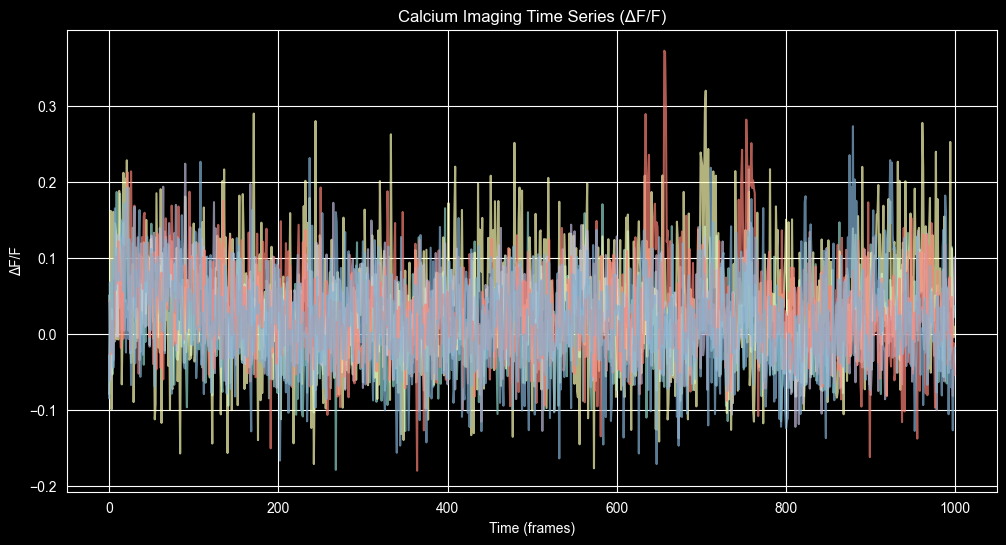

In [65]:
df_over_f_array = nwbfile.processing["ophys"]["DfOverF"]["DfOverF"].data

# Get a subset of the data for visualization
# Note that the `df_over_f_array` has shape `number of frames x number of regions of interest`
# reflecting dimensions of `time x ROIs`
time_series_data = df_over_f_array[:1000, :5]

plt.figure(figsize=(12, 6))
for i in range(time_series_data.shape[1]):
    plt.plot(time_series_data[:, i], alpha=0.7)

plt.xlabel('Time (frames)')
plt.ylabel('ΔF/F')
plt.title('Calcium Imaging Time Series (ΔF/F)')
plt.show()


Note that all data access when reading from an NWB file is 'lazy' in the sense that data arrays are not read into memory
until explicitly requested via slicing operations.

This is particularly useful when working with large (> 60 GB) datasets that
may not otherwise fit into memory.

Additionally, some files on the DANDI archive can be quite large (up to TB-size files in multi-TB Dandisets)!

Instead of downloading these, you can stream data directly from S3 using any of the [libraries supported by PyNWB](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html).

The previous command can be adapted to stream directly from S3 as follows:

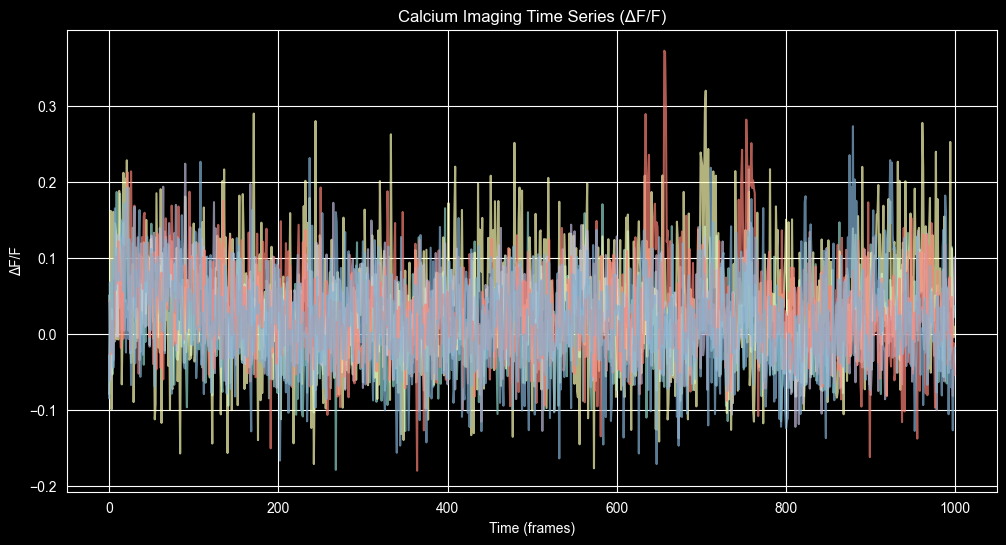

In [81]:
s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)
rem_file = remfile.File(url=s3_url)
h5py_file = h5py.File(name=rem_file, mode="r")
io = NWBHDF5IO(file=h5py_file)
streamed_nwbfile = io.read()

streamed_df_over_f_array = streamed_nwbfile.processing["ophys"]["DfOverF"]["DfOverF"].data

streamed_time_series_data = streamed_df_over_f_array[:1000, :5]

plt.figure(figsize=(12, 6))
for i in range(streamed_time_series_data.shape[1]):
    plt.plot(streamed_time_series_data[:, i], alpha=0.7)

plt.xlabel('Time (frames)')
plt.ylabel('ΔF/F')
plt.title('Calcium Imaging Time Series (ΔF/F)')
plt.show()

<!-- DATA PROVIDER INSTRUCTIONS
The goal here is to visualize some aspect of your dataset in order to help users understand it. In addition to helping users of your dataset understand the dataset, an additional goal is to impress!

Please demonstrate any data preprocessing or reshaping required for your visualization(s).

https://www.reddit.com/r/dataisbeautiful/ for inspiration.
DATA PROVIDER INSTRUCTIONS -->

### Q: A picture is worth a thousand words. Show us a visual (or several!) from your dataset that either illustrates something informative about your dataset, or that you think might excite someone to dig in further.

Using the same Dandiset as the previous section, we can visualize the connection between the segmentation and the
cellular imaging by overlying the summary image with the ROIs.

In [70]:
summary_image = nwbfile.processing["ophys"]["SummaryImages"]["mean_image"].data

plt.figure(figsize=(10, 8))
plt.imshow(summary_image[:], cmap='gray')
plt.title('Mean Summary Image of Imaging Field')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.colorbar(label='Intensity')
plt.tight_layout()
plt.show()

KeyError: "'mean_image' not found in Images 'SummaryImages'."

In [56]:
summary_image = nwbfile.processing["ophys"]["SummaryImages"]["maximum_intensity_projection"]
summary_image

In [58]:
nwbfile.processing["ophys"]["ImageSegmentation"]["PlaneSegmentation"]

# TODO: cody finish making pretty overlay of ROI to max proj

PlaneSegmentation pynwb.ophys.PlaneSegmentation at 0x2619397322256
Fields:
  colnames: ['global_roi_id' 'pixel_mask']
  columns: (
    global_roi_id <class 'hdmf.common.table.VectorData'>,
    pixel_mask_index <class 'hdmf.common.table.VectorIndex'>,
    pixel_mask <class 'hdmf.common.table.VectorData'>
  )
  description: Segmented regions of interest (ROI).
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  imaging_plane: ImagingPlane pynwb.ophys.ImagingPlane at 0x2619397317136
Fields:
  conversion: 1.0
  description: The imaging plane sampled by the two-photon calcium imaging at a depth of {depth} µm.
  device: Microscope pynwb.device.Device at 0x2619441618128
Fields:
  description: A Nikon A1R-MP multiphoton microscope. This system was adapted to provide space to accommodate the behavior apparatus.
  manufacturer: Nikon

  excitation_lambda: 910.0
  grid_spacing: <HDF5 dataset "grid_spacing": shape (2,), type "<f8">
  grid_spacing_unit: micrometers
  indicator: GCaMP6f
  location: VISpm
  optical_channel: (
    OpticalChannel <class 'pynwb.ophys.OpticalChannel'>
  )
  origin_coords_unit: meters
  unit: meters

The examples above showcase optophysiology data, but DANDI hosts diverse neurophysiology modalities.

Let's explore some other data types - such as electrophysiology!

In [ ]:
# TODO: Heberto waveforms

DANDI doesn't just host neural data, either - it is quite common for Dandisets to include behavioral data as well.

Let's take a look at one of the most common behavioral data types - pose estimated video!

In [ ]:
# TODO: Heberto single frame

<!-- DATA PROVIDER INSTRUCTIONS
This section is less prescriptive / freeform than previous sections. The goal here is to show an opinionated example of answering a question using your data. The scale of your dataset may preclude a full example, and so feel free to limit the scope of this example (e.g. work on a subset of data). Users should be able to replicate your example in this notebook, and get a sense of how they would scale up.

A "toy" example is better than no example.

Ideally, your example would:
1. Transmit some of your domain & dataset experience to the reader, drawing on your own work as much as possible
2. Provide a jumping off point for users to extend your work, and do novel work of their own.

DATA PROVIDER INSTRUCTIONS -->

### Q: What is one question that you have answered using these data? Can you show us how you came to that answer?

Focusing on the optophysiology example used above - the Visual Coding project by the Allen Institute - one question
that was addressed involves characterizing population-level response characteristics across
visual cortex.


Multiple stimuli (natural scenes, drifting gratings, static gratings) were presented to each subject over the course
of the experiment. Different structures within the visual cortex were targeted across subjects. The neural responses during each presentation were then characterized to
 show differing response properties across visual areas. This demonstrated that different cortical layers have distinct
 response properties and tuning characteristics. The experiments also quantified how correlated activity between
 neurons affects information coding by showed that noise correlations are stronger between neurons with similar tuning
 properties. Additional findings demonstrate that correlations are modulated by behavioral state (running vs.
 stationary movements).

A full reproducible analysis of this work can be found through its very detailed [example notebook](https://github.com/dandi/example-notebooks/blob/master/000728/AllenInstitute/visual_coding_ophys_tutorial.ipynb).

<!-- DATA PROVIDER INSTRUCTIONS
This section is, like the previous one, intended to be freeform / non-prescriptive. The goal here is to provide a challenge to the community to do something novel with your dataset. That can either be novel in terms of the task, or novel in terms of methodological or computational approach.

Another way to consider this section, is as a wishlist. If you were less constrained by time, cost, skill, etc., what would you like to see achieved using these data? 

The challenge should, however, be somewhat realistic. A challenge that assumes e.g. original data collection, is likely to go unanswered.
DATA PROVIDER INSTRUCTIONS -->

### Q: What is one unanswered question that you think could be answered using these data? Do you have any recommendations or advice for someone wanting to answer this question?

One such proposal might be how do different visual cortical areas (V1, LM, AL, PM) coordinate their activity over time
during naturalistic scene viewing, and can we identify temporal "routing" patterns that predict behavioral state transitions?

While the Visual Coding dataset(s) have characterized individual area responses, differences across cell types, and
other correlations, the temporal dynamics of information flow between areas during natural scene processing remains
less explored - particularly how running vs. stationary states modulate inter-area communication.

It is worth mentioning in this context that the NWB group hosts a regular [NeuroDataReHack event](https://nwb.org/events/hck26-2026-janelia-ndrh/)
where researchers are brought together to work precisely on such questions of how to analyze existing datasets in
novel ways, rather than running entirely new experiments. Check the [NWB Events](https://nwb.org/events/) page and
sign up for the newsletter to stay informed about these kinds of events!